# Potential Talents - An Apziva Project (#3)

# Proceed to the [previous notebook](potential_talents_pt1.ipynb) to view the EDA and initial NLP work.

# Modeling

By Samuel Alter

Apziva: 6bImatZVlK6DnbEo

## Project Overview

We are working with a talent sourcing and management company to help them surface candidates that are a best fit for their human resources job post. We are using a dataset of job candidates' job titles, their location, and their number of LinkedIn connections.

### Goals

Produce a probability, between 0 and 1, of how closely the candidate fits the job description of **"Aspiring human resources"** or **"Seeking human resources."** After an initial recommendation pulls out a candidate(s) to be starred for future consideration, the recommendation will be re-run and new "stars" will be awarded.

To help predict how the candidates fit, we are tracking the performance of two success metrics:
* Rank candidates based on a fitness score
* Re-rank candidates when a candidate is starred

We also need to do the following:
* Explain how the algorithm works and how the ranking improves after each starring iteration
* How to filter out candidates which should not be considered at all
* Determine a cut-off point (if possible) that would work for other roles without losing high-potential candidates
* Ideas to explore on automating this procedure to reduce or eliminate human bias

### The Dataset

| Column | Data Type | Comments |
|---|---|---|
| `id` | Numeric | Unique identifier for the candidate |
| `job_title` | Text | Job title for the candidate |
| `location` | Text | Geographic location of the candidate |
| `connections` | Text | Number of LinkedIn connections for the candidate |

Connections over 500 are encoded as "500+". Some do not have specific locations listed and just had their country, so I substituted capitol cities or geographic centers to represent those countries.

# Imports and Helper Functions

In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
from torchview import draw_graph
import torch.nn.functional as F
from collections import defaultdict

In [440]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [441]:
seed=rand_gen()
seed

6071

In [442]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x311208200

In [443]:
def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

# Learning to Rank (LTR) systems 

[RankNet](https://icml.cc/Conferences/2015/wp-content/uploads/2015/06/icml_ranking.pdf) is an influential algorithm that is designed to rank items given an objective. LTR systems are used for information retrieval, which is crucial for search engines, recommender systems like on Netflix or Amazon, travel agencies, and online advertising.

You can learn more about LTR systems from [this](https://towardsdatascience.com/learning-to-rank-a-complete-guide-to-ranking-using-machine-learning-4c9688d370d4) Medium post by [Francesco Casalegno](https://medium.com/@francesco.casalegno).

RankNet uses a "pairwise" method of training, meaning it predices which item in a pair should be ranked higher based on a probabilistic model. With pairs of items, using RankNet makes our task a binary classification problem.

## RankNet NN

### `device` Setup

In [444]:
# get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


### `RankNet` class

RankNet, a pairwise ranking algorithm, is defined by its specific ranking methodology rather than the specifics of its architecture. It is defined by:
* **Pairwise comparison** of pairs of inputs
* **Sigmoid-based** probability output
* **Loss function** involving **Binary Cross-Entropy Loss** to compute error between predicted probabilities and true pairwise labels
* **Backpropagation and gradient decent** allows for training and updating weights using gradients calculated from the pairwise ranking loss

The architecture is not fixed and we can:
* Add or remove layers
* Change the number of neurons in the hidden layers
* Adjust activation functions
* Change dropout rates

In [445]:
class RankNet(nn.Module):
    def __init__(self, n_feature):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_feature, 512),
            nn.BatchNorm1d(512), # normalization
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256), # another round of normalization
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
        
    def forward(self, input_1, input_2):
        # define inputs and handle potentail length issue
        input_1 = input_1.to(device).float().unsqueeze(0) if len(input_1.shape) == 1 else input_1
        input_2 = input_2.to(device).float().unsqueeze(0) if len(input_2.shape) == 1 else input_2
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        return s1 - s2

#### Hyperparameter definitions

In [446]:
# retrieve shape of tensors from file produced in Part 1
with open('../joblib/3_n_feature.txt', 'r') as file:
    num_features = int(file.read())
    print('num_features:',num_features)

n_feature = num_features
learning_rate = 0.01
batch_size = 64
epochs = 25

num_features: 384


### Load training and testing data

Now that we have the neural network defined, we need to load the training files saved as parquet from the end of Part 1 of the project.

In [447]:
# load data
train_data = pd.read_parquet('../joblib/3_pairs_train.parquet', engine='pyarrow')
test_data = pd.read_parquet('../joblib/3_pairs_test.parquet', engine='pyarrow')

In [448]:
# load data from parquet files
train_input_1 = torch.tensor(train_data['input_1'].tolist(), dtype=torch.float32)
train_input_2 = torch.tensor(train_data['input_2'].tolist(), dtype=torch.float32)
train_labels = torch.tensor(train_data['label'].tolist(), dtype=torch.float32)

# preserve IDs for later use (but exclude them from model input)
train_ids_1 = train_data['id_1'].tolist()
train_ids_2 = train_data['id_2'].tolist()

test_input_1 = torch.tensor(test_data['input_1'].tolist(), dtype=torch.float32)
test_input_2 = torch.tensor(test_data['input_2'].tolist(), dtype=torch.float32)
test_labels = torch.tensor(test_data['label'].tolist(), dtype=torch.float32)

test_ids_1 = test_data['id_1'].tolist()
test_ids_2 = test_data['id_2'].tolist()

# create TensorDataset without IDs (they're stored separately)
train_dataset = TensorDataset(train_input_1, train_input_2, train_labels)
test_dataset = TensorDataset(test_input_1, test_input_2, test_labels)

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training loop

#### Define loss function, optimizer, and instantiate model

In [449]:
def train(model, train_loader, loss_fn, optimizer, device, epochs=50):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            input_1, input_2, labels = batch
            input_1, input_2, labels = input_1.to(device), input_2.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_1, input_2).squeeze()

            # Calculate loss
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()

            # Calculate accuracy (threshold 0.5 for binary classification)
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

In [450]:
rank_net = RankNet(n_feature=n_feature).to(device)
loss_fn = nn.BCEWithLogitsLoss() # binary cross-entropy loss with logits
optimizer = torch.optim.Adam(rank_net.parameters(), lr=learning_rate)
print(rank_net)

RankNet(
  (model): Sequential(
    (0): Linear(in_features=384, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [451]:
# visualize RankNet
from torchviz import make_dot

# create a dummy input tensor to visualize the model (example: 1 sample with 'n_feature' features)
dummy_input = torch.randn(1, n_feature).to(device)

# generate the graph (make_dot creates a directed graph from the model)
rank_net.eval()  # Put model in evaluation mode
output = rank_net(dummy_input, dummy_input)  # Using dummy input for both inputs in RankNet

# create the dot graph (this is a visualization of the model's architecture)
dot = make_dot(output, params=dict(rank_net.named_parameters()))

# render and display the graph
dot.render('figures/3_ranknet_architecture.jpg', format='jpg', view=True)  # saves and views the plot

'figures/3_ranknet_architecture.jpg.jpg'

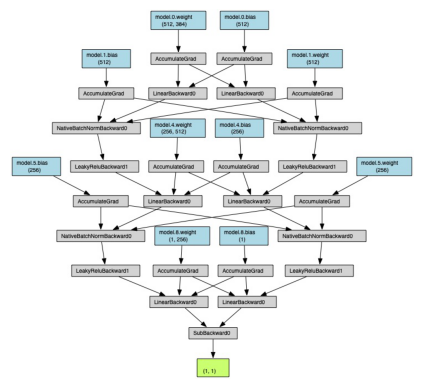

In [452]:
# view architecture
import matplotlib.image as mpimg
img = mpimg.imread('figures/3_ranknet_architecture.jpg.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [453]:
train(rank_net, train_loader, loss_fn, optimizer, device, epochs)

Epoch [1/25], Loss: 0.7230, Accuracy: 0.5833
Epoch [2/25], Loss: 0.6536, Accuracy: 0.6286
Epoch [3/25], Loss: 0.6267, Accuracy: 0.6401
Epoch [4/25], Loss: 0.6072, Accuracy: 0.6604
Epoch [5/25], Loss: 0.5941, Accuracy: 0.6643
Epoch [6/25], Loss: 0.5769, Accuracy: 0.6790
Epoch [7/25], Loss: 0.5787, Accuracy: 0.6720
Epoch [8/25], Loss: 0.5664, Accuracy: 0.6884
Epoch [9/25], Loss: 0.5604, Accuracy: 0.6860
Epoch [10/25], Loss: 0.5621, Accuracy: 0.6804
Epoch [11/25], Loss: 0.5521, Accuracy: 0.6907
Epoch [12/25], Loss: 0.5493, Accuracy: 0.6984
Epoch [13/25], Loss: 0.5492, Accuracy: 0.6951
Epoch [14/25], Loss: 0.5470, Accuracy: 0.7106
Epoch [15/25], Loss: 0.5468, Accuracy: 0.6998
Epoch [16/25], Loss: 0.5497, Accuracy: 0.6926
Epoch [17/25], Loss: 0.5475, Accuracy: 0.6984
Epoch [18/25], Loss: 0.5377, Accuracy: 0.7056
Epoch [19/25], Loss: 0.5426, Accuracy: 0.6940
Epoch [20/25], Loss: 0.5426, Accuracy: 0.6977
Epoch [21/25], Loss: 0.5477, Accuracy: 0.6965
Epoch [22/25], Loss: 0.5387, Accuracy: 0.70

### Evaluate model and match IDs with predictions

In [454]:
def test(model, test_loader, loss_fn, device, test_ids_1, test_ids_2, batch_size):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct_predictions = 0
    total_samples = 0

    predictions = []
    id_pairs = []  # Store the associated IDs for each prediction

    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            input_1, input_2, labels = batch
            input_1, input_2, labels = input_1.to(device), input_2.to(device), labels.to(device)

            # Forward pass
            outputs = model(input_1, input_2).squeeze()

            # Calculate loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Store predictions and IDs
            predicted_probs = torch.sigmoid(outputs).cpu().numpy()
            predictions.extend(predicted_probs)

            # Track the associated ID pairs for each batch
            id_pairs.extend(zip(test_ids_1[idx * batch_size:(idx + 1) * batch_size],
                                test_ids_2[idx * batch_size:(idx + 1) * batch_size]))

    # Calculate final metrics
    test_accuracy = correct_predictions / total_samples
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Match predictions to IDs
    results = pd.DataFrame({
        'id_1': [pair[0] for pair in id_pairs],
        'id_2': [pair[1] for pair in id_pairs],
        'predicted_prob': predictions,
    })

    return results

In [455]:
results = test(rank_net, test_loader, loss_fn, device, test_ids_1, test_ids_2, batch_size)
print(results.head())  # display the first few results

Test Loss: 0.6485, Test Accuracy: 0.6138
   id_1  id_2  predicted_prob
0    73   101        0.548676
1    33    57        0.505064
2    47   100        0.597444
3    20    75        0.826877
4    27    32        0.775653


#### Save RankNet model

In [456]:
path = Path("../joblib/3_ranknet_trained.pth")
torch.save(rank_net.state_dict(), path)
print(f"Saved PyTorch model state to {path}")

Saved PyTorch model state to ../joblib/3_ranknet_trained.pth


#### Load RankNet model (optional)

In [457]:
# # recreate model instance
# rank_net_loaded = RankNet(n_feature=n_feature).to(device)
# rank_net_loaded.load_state_dict(torch.load(path, map_location=device))

# # evaluate model on new data (example)
# rank_net_loaded.eval()  # set to evaluation mode

# # example new data (you can replace this with actual new input data)
# new_input_1 = torch.tensor([[0.5, 1.2, -0.3, 0.8]], dtype=torch.float32)  # Replace with actual feature data
# new_input_2 = torch.tensor([[0.7, -1.0, 0.5, 1.0]], dtype=torch.float32)  # Replace with actual feature data

# # move inputs to the same device as the model
# new_input_1 = new_input_1.to(device)
# new_input_2 = new_input_2.to(device)

# # forward pass through the model
# with torch.no_grad():  # no need to track gradients during evaluation
#     output = rank_net_loaded(new_input_1, new_input_2)
    
# # convert logits to probabilities
# predicted_prob = torch.sigmoid(output).item()  # get a single probability value

# # print the result
# print(f"Predicted Probability of input_1 ranking higher than input_2: {predicted_prob:.4f}")

#### Track which candidates "won" more

In [458]:
# initialize a dictionary to count the number of "wins" for each candidate
rank_scores = defaultdict(int)

# aggregate results: count how often each ID is ranked higher
for _, row in results.iterrows():
    id_1, id_2, predicted_prob = row['id_1'], row['id_2'], row['predicted_prob']
    
    # if predicted probability is greater than 0.5, id_1 is ranked higher
    if predicted_prob > 0.5:
        rank_scores[id_1] += 1
    else:
        rank_scores[id_2] += 1

# sort candidates by their score (higher is better)
final_ranking = sorted(rank_scores.items(), key=lambda x: x[1], reverse=True)

# print top 10 rows
# for rank, (candidate_id, score) in enumerate(final_ranking[:10], 1):
#     print(f"Rank {rank}: Candidate ID {int(candidate_id)} with score {score}")

final_ranking_df = pd.DataFrame(data=final_ranking, columns=['id','score'])
final_ranking_df['id'] = pd.to_numeric(final_ranking_df['id'],
                                      downcast='integer', errors='coerce').astype(str)
final_ranking_df.head(10)

,id,score
0,92,28
1,82,24
2,32,22
3,28,21
4,85,21
5,27,20
6,60,20
7,47,19
8,22,19
9,24,19


#### Plot results

In [459]:
# read in original data
df = pd.read_csv('../data/3_data.csv')
df['id'] = df['id'].astype(str)
final_ranking_df['id'] = final_ranking_df['id'].astype(str)

# add job_titles to final_ranking_df to match the IDs
final_ranking_merged = pd.merge(final_ranking_df, df[['id','job_title']], on='id', how='left')
final_ranking_merged.head()

,id,score,job_title
0,92,28,Seeking employment opportunities within Custom...
1,82,24,Aspiring Human Resources Professional | An ene...
2,32,22,Native English Teacher at EPIK (English Progra...
3,28,21,Seeking Human Resources Opportunities
4,85,21,RRP Brand Portfolio Executive at JTI (Japan To...


In [460]:
# check to make sure it worked - this job title should match above
first_row = final_ranking_merged[:1]['id'][0] # get id
df[['id','job_title']][df['id']==first_row]

,id,job_title
91,92,Seeking employment opportunities within Custom...


In [461]:
# save dataframe
final_ranking_merged.to_csv('../joblib/3_pt2_cumulative_scores.csv')

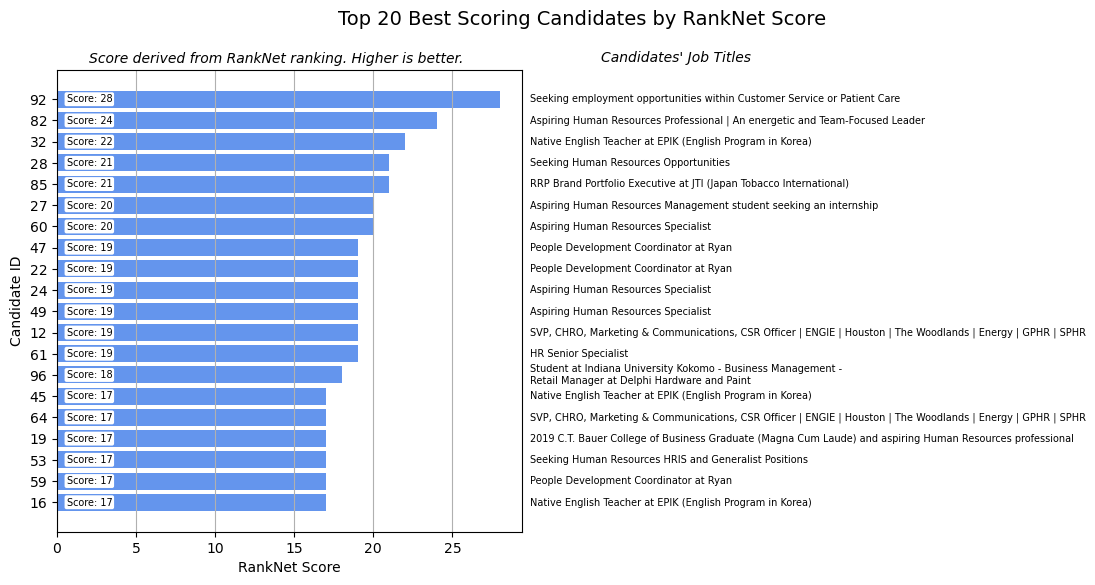

In [462]:
cutoff = 20

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 6))
plt.gca().invert_yaxis()
plt.barh(y=final_ranking_merged[:cutoff]['id'], 
         width=final_ranking_merged[:cutoff]['score'], 
         color='cornflowerblue')

xmax = ax.get_xlim()[1]
xmin = ax.get_xlim()[0]
ymax = ax.get_ylim()[1]
ymin = ax.get_ylim()[0]

# Add labels with scores from specified columns on the bars
for index, row in final_ranking_merged[:cutoff].iterrows():
    # Format the text to display the scores for each bar
    label = (
        f"Score: {row['score']:.0f}"
    )
    plt.text(
        0.6, # distance from y-axis
        row['id'], 
        label,
        ha='left',
        va='center',
        fontsize=7,
        color='black', # text color
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2') # White background
    )

    # add the job_title to each corresponding applicant
    plt.text(
        xmax + 0.5,
        row['id'],
        f"{row['job_title']}",
        ha='left',
        va='center',
        fontsize=7,
        color='black'
    )
    
# Add labels and title for clarity
plt.ylabel('Candidate ID')
plt.xlabel('RankNet Score')
plt.suptitle(f'Top {cutoff} Best Scoring Candidates by RankNet Score', fontsize=14, x=1)

# add subtitle
axes=plt.gca()
ylim=axes.get_ylim()
plt.text(x=2, y=ymax-0.5, # position just above highest y-limit, note that axes are inverted
         s='Score derived from RankNet ranking. Higher is better.', fontsize=10, style='italic', ha='left', va='center')
plt.text(x=xmax+5, y=ymax-0.4,
         s="Candidates' Job Titles", fontsize=10, style='italic')
plt.grid(axis='x')

plt.savefig('figures/3_ranknet_results.pdf',bbox_inches='tight')
plt.savefig('figures/3_ranknet_results.jpg',bbox_inches='tight')
plt.savefig('figures/3_ranknet_results.png',bbox_inches='tight')

plt.show()

In [463]:
# confirm the plot shows what we expect
df[df['id']=='92']

,id,job_title,location,connection,fit
91,92,Seeking employment opportunities within Custom...,"Torrance, California",64,NaN


We will wait to compare the results once we have run through the next notebook... stay tuned!

## LambdaRank

In [464]:
# to install pandas, use
# pip install 'lightgbm[pandas]'
# or
# pip install 'lightgbm[scikit-learn]'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import torch
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import optuna

# use
# pip install optuna-integration[lightgbm]
from optuna.integration import LightGBMPruningCallback

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="sklearn")

In an effort to explore other ranking algorithms, we will now turn to LambdaRank. It is an evolution of the RankNet algorithm that we worked on above. While RankNet looks to optimize pairwise accuracy, LambdaRank optimizes for ranking metrics like NDCG, or Normalized Discounted Cumulative Gain. It does not require pairwise comparisons as input. 

NDCG checks not only if the first item should be ranked higher than the second, but also how much swapping their order would improve the final ranking. The gain can be thought of this way: if a relevant item is placed close to the top, it will have a greater gain than if a relevant item was placed towards the bottom. 

LambdaRank uses **lambdas** that help adjust the model's focus to help improve the overall ranking quality, while RankNet takes advantage of a loss function and cares about individual rankings.

You can read more about LambdaRank [here](https://tamaracucumides.medium.com/learning-to-rank-with-lightgbm-code-example-in-python-843bd7b44574). There's a short snippet of information about LambdaRank [from Microsoft](https://www.microsoft.com/en-us/research/publication/from-ranknet-to-lambdarank-to-lambdamart-an-overview/). Researchers there designed the algorithm.

[This repository](https://github.com/Ransaka/LTR-with-LIghtGBM) gives a good example of how to implement the algorithm.

LambdaRank uses the LightGBM algorithm and requires the following:
* **Feature matrix (X)** of each item
* **Relevance scores (y)** for each item
* "**Groups**," or the number of items per query group 

In [465]:
# get random seed from project
with open('seed.txt', 'r') as file:
    seed = int(file.read())
    
seed

2870

In [466]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x31120AA40

In [467]:
# load the job title data
loaded_data = np.load('../joblib/3_data_job_titles.npz', allow_pickle=True)
job_title_sbert = [np.array(embedding) for embedding in loaded_data['embeddings']]
print(f"Loaded {len(job_title_sbert)} embeddings. First element type: {type(job_title_sbert[0])}")

Loaded 104 embeddings. First element type: <class 'numpy.ndarray'>


In [468]:
# convert back to tensors
job_title_tensors = [torch.tensor(embedding) for embedding in job_title_sbert]

In [469]:
# check
job_title_tensors[0]

tensor([-7.1764e-02,  2.2637e-03, -1.7858e-02,  3.1808e-02,  8.6310e-03,
         4.5645e-02, -6.7703e-02,  3.1216e-02,  1.8814e-02, -3.6150e-04,
        -1.5786e-02, -3.0461e-02, -8.2910e-02, -5.0705e-02, -7.0172e-02,
         3.2520e-02,  9.6550e-03, -8.0883e-02,  4.6644e-02, -3.8407e-02,
         2.3128e-02,  3.6828e-02, -1.5138e-03, -9.5810e-02, -2.7337e-02,
        -3.0467e-02, -1.6989e-02, -2.4439e-02, -2.1443e-04, -3.0366e-03,
         1.0420e-02,  5.6600e-03,  2.4441e-02,  3.2096e-02,  6.2465e-02,
         6.9278e-02,  4.4225e-02, -1.1663e-02,  1.5852e-01,  3.1511e-02,
        -9.2587e-03, -8.1887e-02, -2.8538e-02,  3.3625e-02, -6.5775e-03,
        -5.9914e-02,  2.1527e-02, -3.0205e-02,  3.8459e-02, -8.4312e-03,
        -7.3194e-02, -6.0277e-02,  3.9353e-02, -4.5725e-02,  2.8139e-02,
         3.0143e-02,  2.7823e-02, -1.5330e-02,  6.5976e-03, -6.2322e-02,
        -1.5916e-02, -3.1975e-02,  2.1324e-02,  3.4776e-02,  8.1722e-02,
         5.2771e-03, -5.2103e-02,  2.3793e-02,  3.8

In [470]:
# load candidate ID and rank data
with open('../joblib/candidate_ids.pkl', 'rb') as f:
    candidate_ids = pickle.load(f)

with open('../joblib/ranks.pkl', 'rb') as f:
    ranks = pickle.load(f)
    
print("Data loaded successfully.")

Data loaded successfully.


In [471]:
# check
candidate_ids[:5]

[1, 2, 3, 4, 5]

In [472]:
# check
ranks[:5]

[1, 1, 2, 2, 16]

### Prepare the data

Now that we have our work from the previous notebook loaded, we will adapt them to the needs of the LambdaRank algorithm:
* **Feature matrix (X)** will be the `job_titles`
* **Relevance scores (y)** will be the `ranks`
* **Group** equals `1` as we're looking at all candidates

In [473]:
# convert ranks to relevance scores (invert ranks: higher rank -> higher score)
# example: if ranks are 1, 2, 3, scores become 3, 2, 1.
relevance_scores = np.max(ranks) - np.array(ranks) + 1

# feature matrix (X) from job_titles
X = np.array([job.detach().cpu().numpy() for job in job_title_tensors])

# we'll define group in the next code cell

print('Done.')

Done.


### Split the data

In [474]:
# split data into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, relevance_scores, test_size=0.2, random_state=seed
)

group_train_val = [len(X_train_val)]
group_test = [len(X_test)]

# split val set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=seed
) # 0.25 x (1.0 - test_size) = 0.2, so validation set is 20% of the original data

group_train = [len(X_train)]
group_val = [len(X_val)]

print('Done.')

Done.


### Train the LambdaRank model

In [475]:
# initialize LambdaRank model
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    boosting_type='gbdt',
    metric='ndcg', # evaluation metric
    n_estimators=100,
    learning_rate=0.1,
    importance_type='gain',
    random_state=seed
)

# train model
ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5, 10] # evaluate nDCG at 5 and 10
)

LGBMRanker(importance_type='gain', metric='ndcg', objective='lambdarank',
           random_state=2870)

### Test, evaluate, and plot

In [476]:
# predict relevance scores
y_pred = ranker.predict(X_test)

# sort test data by predicted relevance
sorted_indices = np.argsort(-y_pred)  # descending order
sorted_candidates = np.array(candidate_ids)[sorted_indices]
sorted_relevance = y_pred[sorted_indices]

for candidate, score in zip(sorted_candidates, sorted_relevance):
    print(f'Candidate ID: {candidate}, Predicted score: {score}')

Candidate ID: 4, Predicted score: 0.6831914069355659
Candidate ID: 6, Predicted score: 0.6831914069355659
Candidate ID: 12, Predicted score: 0.3220738111400713
Candidate ID: 7, Predicted score: -0.08345109119203761
Candidate ID: 20, Predicted score: -0.38079116232617805
Candidate ID: 10, Predicted score: -0.5287622853540623
Candidate ID: 8, Predicted score: -0.6810206733100771
Candidate ID: 1, Predicted score: -0.8063554906169652
Candidate ID: 5, Predicted score: -0.8063554906169652
Candidate ID: 14, Predicted score: -0.9363888925878047
Candidate ID: 3, Predicted score: -1.1099522058990874
Candidate ID: 21, Predicted score: -1.1579183721186497
Candidate ID: 17, Predicted score: -1.1596234836195072
Candidate ID: 13, Predicted score: -1.3191721782739276
Candidate ID: 18, Predicted score: -1.3280857072905452
Candidate ID: 9, Predicted score: -1.3280857072905452
Candidate ID: 15, Predicted score: -1.3971962323856422
Candidate ID: 11, Predicted score: -1.3971962323856422
Candidate ID: 2, Pr

In [477]:
# define true relevance
# sorted by prediction order
true_relevance = relevance_scores[sorted_indices]

# compute NDCG at k
ndcg = ndcg_score([true_relevance], [sorted_relevance], k=5)
print(f'NDCG@5: {ndcg:.4f}')

NDCG@5: 0.9223


A score of close to 1.0 means that the model did a good job of prioritizing the most relevant candidates.

In [478]:
def mean_reciprocal_rank(y_true, y_pred):
    # sort by predicted relevance (descending)
    sorted_indices = np.argsort(-y_pred)
    # align true relevance with predictions
    y_true_sorted = np.array(y_true)[sorted_indices]

    for i, relevance in enumerate(y_true_sorted):
        if relevance > 0:  # Find first relevant item
            return 1 / (i + 1)
    return 0  # no relevant items found

mrr = mean_reciprocal_rank(true_relevance, sorted_relevance)
print(f'MRR: {mrr:.4f}')

MRR: 1.0000


The MRR is the average of the reciprocal ranks (1 for first place, 1/2 for second place, 1/3 for third place, and so on). Values closer to 1 mean that the model did a good job of ordering candidates.

In [479]:
# Define objective function
def objective(trial):
    params = {
        'objective': 'lambdarank',
        'boosting_type': 'gbdt',
        'metric': 'ndcg',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
        'random_state': seed,
        'verbose': -1
    }
    
    ranker = lgb.LGBMRanker(**params)
    ranker.fit(
        X_train, y_train,
        group=group_train,
        eval_set=[(X_val, y_val)],
        eval_group=[group_val],
        eval_at=[5],
        callbacks=[LightGBMPruningCallback(trial, 'ndcg@5')]
    )
    
    # Evaluate on validation set
    y_val_pred = ranker.predict(X_val)
    ndcg_val = ndcg_score([y_val], [y_val_pred], k=5)
    return ndcg_val

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best parameters
print("Best parameters:", study.best_params)

[I 2024-12-10 20:24:07,810] A new study created in memory with name: no-name-c8cec7cb-e08a-4ddc-bf28-b97d21d990ef
[I 2024-12-10 20:24:07,834] Trial 0 finished with value: 0.2780234140403975 and parameters: {'n_estimators': 171, 'learning_rate': 0.27026694840969523, 'num_leaves': 90, 'min_child_samples': 43, 'lambda_l1': 0.5850569742317087, 'lambda_l2': 0.15082882303484757}. Best is trial 0 with value: 0.2780234140403975.
[I 2024-12-10 20:24:07,914] Trial 1 finished with value: 0.2780234140403975 and parameters: {'n_estimators': 499, 'learning_rate': 0.12227102628838502, 'num_leaves': 88, 'min_child_samples': 38, 'lambda_l1': 0.8512311310447898, 'lambda_l2': 0.7274901159735736}. Best is trial 0 with value: 0.2780234140403975.
[I 2024-12-10 20:24:08,073] Trial 2 finished with value: 0.44483628264122543 and parameters: {'n_estimators': 245, 'learning_rate': 0.07409844026939551, 'num_leaves': 80, 'min_child_samples': 22, 'lambda_l1': 0.149492855821021, 'lambda_l2': 0.8099170774096041}. Bes

[I 2024-12-10 20:24:10,503] Trial 28 finished with value: 0.44483628264122543 and parameters: {'n_estimators': 147, 'learning_rate': 0.23997972600056422, 'num_leaves': 51, 'min_child_samples': 16, 'lambda_l1': 0.18099383400983432, 'lambda_l2': 0.08055620415625661}. Best is trial 10 with value: 0.5440217798834552.
[I 2024-12-10 20:24:10,609] Trial 29 finished with value: 0.44483628264122543 and parameters: {'n_estimators': 229, 'learning_rate': 0.09313874128348533, 'num_leaves': 91, 'min_child_samples': 25, 'lambda_l1': 0.3051641909918954, 'lambda_l2': 0.1389440728258387}. Best is trial 10 with value: 0.5440217798834552.
[I 2024-12-10 20:24:10,696] Trial 30 finished with value: 0.5233853870104085 and parameters: {'n_estimators': 165, 'learning_rate': 0.13970761267909598, 'num_leaves': 74, 'min_child_samples': 8, 'lambda_l1': 0.06513809572672404, 'lambda_l2': 0.31973284912911387}. Best is trial 10 with value: 0.5440217798834552.
[I 2024-12-10 20:24:10,771] Trial 31 finished with value: 0

Best parameters: {'n_estimators': 284, 'learning_rate': 0.1912198704771869, 'num_leaves': 100, 'min_child_samples': 5, 'lambda_l1': 0.04227109893006681, 'lambda_l2': 0.41558235052106407}


In [480]:
best_params = study.best_params

# add verbosity to quiet LightGBM
best_params['verbose_eval'] = -1
best_params['verbose'] = -1
best_params['random_state'] = seed

print(best_params)

{'n_estimators': 284, 'learning_rate': 0.1912198704771869, 'num_leaves': 100, 'min_child_samples': 5, 'lambda_l1': 0.04227109893006681, 'lambda_l2': 0.41558235052106407, 'verbose_eval': -1, 'verbose': -1, 'random_state': 2870}


In [481]:
ranker = lgb.LGBMRanker(**best_params)

# train model
ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5, 10] # evaluate nDCG at 5 and 10
)

# predict relevance scores
y_pred = ranker.predict(X_test)

# sort test data by predicted relevance
sorted_indices = np.argsort(-y_pred)  # descending order
sorted_candidates = np.array(candidate_ids)[sorted_indices]
sorted_relevance = y_pred[sorted_indices]

for candidate, score in zip(sorted_candidates, sorted_relevance):
    print(f'Candidate ID: {candidate}, Predicted score: {score}')
    
# define true relevance
# sorted by prediction order
true_relevance = relevance_scores[sorted_indices]

# compute NDCG at k
k = 5
ndcg = ndcg_score([true_relevance], [sorted_relevance], k=k)
print(f'NDCG@{k}: {ndcg:.4f}')

def mean_reciprocal_rank(y_true, y_pred):
    # sort by predicted relevance (descending)
    sorted_indices = np.argsort(-y_pred)
    # align true relevance with predictions
    y_true_sorted = np.array(y_true)[sorted_indices]

    for i, relevance in enumerate(y_true_sorted):
        if relevance > 0:  # Find first relevant item
            return 1 / (i + 1)
    return 0  # no relevant items found

mrr = mean_reciprocal_rank(true_relevance, sorted_relevance)
print(f'MRR: {mrr:.4f}')

Candidate ID: 4, Predicted score: 1.0989101203622116
Candidate ID: 6, Predicted score: 1.0989101203622116
Candidate ID: 12, Predicted score: 0.8225828298969986
Candidate ID: 8, Predicted score: -0.33669731612140635
Candidate ID: 7, Predicted score: -0.42432332049613714
Candidate ID: 21, Predicted score: -1.0241594757188701
Candidate ID: 1, Predicted score: -1.074593568657621
Candidate ID: 5, Predicted score: -1.074593568657621
Candidate ID: 20, Predicted score: -1.1100249545530574
Candidate ID: 14, Predicted score: -1.1961436198036102
Candidate ID: 10, Predicted score: -1.2981305453162562
Candidate ID: 3, Predicted score: -1.4315839582780605
Candidate ID: 9, Predicted score: -1.641600298435425
Candidate ID: 18, Predicted score: -1.641600298435425
Candidate ID: 13, Predicted score: -1.8995707088711833
Candidate ID: 17, Predicted score: -1.9817194887910976
Candidate ID: 2, Predicted score: -2.284035212110949
Candidate ID: 16, Predicted score: -2.284035212110949
Candidate ID: 19, Predicte

Interestingly, the tuned model produced a worse result. We will use the base model for our visualization and wrap-up.

#### Plot results

Again, we are using the base algorithm as it gave us a better NDCG score.

In [482]:
# initialize LambdaRank model
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    boosting_type='gbdt',
    metric='ndcg', # evaluation metric
    n_estimators=100,
    learning_rate=0.1,
    importance_type='gain',
    random_state=seed
)

# train model
ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5, 10] # evaluate nDCG at 5 and 10
)

# predict relevance scores
y_pred = ranker.predict(X_test)

# sort test data by predicted relevance
sorted_indices = np.argsort(-y_pred)  # descending order
sorted_candidates = np.array(candidate_ids)[sorted_indices]
sorted_relevance = y_pred[sorted_indices]
true_relevance = relevance_scores[sorted_indices] # define true relevance sorted by prediction order

for candidate, score in zip(sorted_candidates, sorted_relevance):
    print(f'Candidate ID: {candidate}, Predicted score: {score}')

# compute evaluation metrics
def compute_metrics(y_true, y_pred, k=5):
    ndcg = ndcg_score([y_true], [y_pred], k=k)
    mrr = mean_reciprocal_rank(y_true, y_pred)
    return ndcg, mrr

k = 5
ndcg, mrr = compute_metrics(true_relevance, sorted_relevance, k=k)
print(f'NDCG@5, k={k}: {ndcg:.4f}')
print(f'MRR: {mrr:.4f}')

Candidate ID: 4, Predicted score: 0.6831914069355659
Candidate ID: 6, Predicted score: 0.6831914069355659
Candidate ID: 12, Predicted score: 0.3220738111400713
Candidate ID: 7, Predicted score: -0.08345109119203761
Candidate ID: 20, Predicted score: -0.38079116232617805
Candidate ID: 10, Predicted score: -0.5287622853540623
Candidate ID: 8, Predicted score: -0.6810206733100771
Candidate ID: 1, Predicted score: -0.8063554906169652
Candidate ID: 5, Predicted score: -0.8063554906169652
Candidate ID: 14, Predicted score: -0.9363888925878047
Candidate ID: 3, Predicted score: -1.1099522058990874
Candidate ID: 21, Predicted score: -1.1579183721186497
Candidate ID: 17, Predicted score: -1.1596234836195072
Candidate ID: 13, Predicted score: -1.3191721782739276
Candidate ID: 18, Predicted score: -1.3280857072905452
Candidate ID: 9, Predicted score: -1.3280857072905452
Candidate ID: 15, Predicted score: -1.3971962323856422
Candidate ID: 11, Predicted score: -1.3971962323856422
Candidate ID: 2, Pr

This figure below is replicated in the second figure at the end of this notebook, rendering it redundant.

In [483]:
# # use sorted_candidates as the x-axis categories in the proper order
# plt.bar(range(len(sorted_candidates)), sorted_relevance, color='cornflowerblue')

# # adjust x-axis labels
# plt.xticks(
#     ticks=range(len(sorted_candidates)), # positions
#     labels=sorted_candidates,            # candidate IDs in proper order
#     rotation=90, 
#     fontsize=8
# )

# # labels and title
# plt.xlabel('Candidate IDs (sorted by predicted relevance)', fontsize=12)
# plt.ylabel('Predicted Relevance Score', fontsize=12)
# plt.title('Predicted Relevance Scores (Descending)', fontsize=14)
# plt.xticks(rotation=0)

# # grid and layout adjustments
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()

# plt.savefig('figures/3_predicted_relevance.jpg', bbox_inches='tight')

# plt.show()

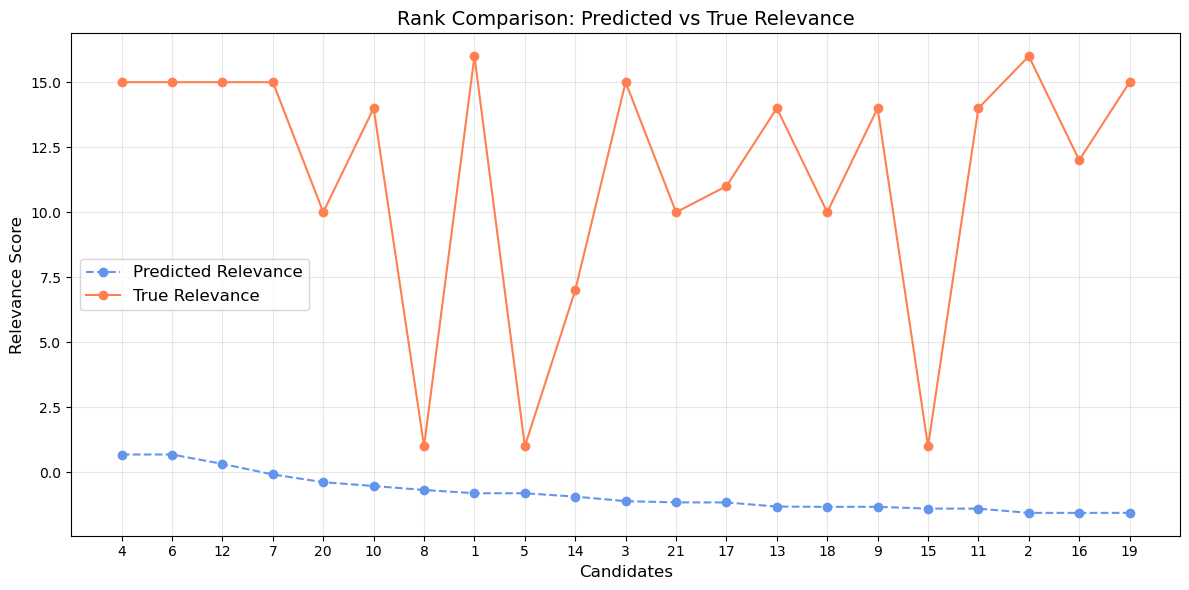

In [484]:
N = len(sorted_candidates)
top_sorted_relevance = sorted_relevance[:N]
top_true_relevance = true_relevance[:N]
top_candidates = sorted_candidates[:N]  # for x-axis labeling

plt.figure(figsize=(12, 6))

# plot predicted relevance scores
plt.plot(
    range(N),
    top_sorted_relevance,
    label='Predicted Relevance',
    marker='o',
    linestyle='--',
    color='cornflowerblue'
)

# annotate predicted scores
# for i, score in enumerate(top_sorted_relevance):
#     plt.text(i, score, f"{score:.2f}", fontsize=8, color='blue', ha='center')

# plot true relevance scores
plt.plot(
    range(N),
    top_true_relevance,
    label='True Relevance',
    marker='o',
    linestyle='-',
    color='coral'
)

# annotate true scores
# for i, score in enumerate(top_true_relevance):
#     plt.text(i, score, f"{score:.2f}", fontsize=8, color='red', ha='center')

# set x-axis with top candidate IDs
plt.xticks(range(N), labels=top_candidates, fontsize=10)

plt.xlabel('Candidates', fontsize=12)
plt.ylabel('Relevance Score', fontsize=12)
plt.title('Rank Comparison: Predicted vs True Relevance', fontsize=14)

plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('figures/3_predicted_vs_true_relevance.jpg', bbox_inches='tight')

plt.show()

If we look at the predicted relevance first, we see that each bar represents a candidate ID with its predicted score on the y-axis. The model is showing that candidate 4 and 6 have the most relevance to the target, while 16 and 19 have the least.

Comparing the predicted relevance to the true relevance shows that the model is not able to align with the true labels. Although it achieved high NDCG and MRR scores, there are only 21 candidates in the test set and 104 candidates in the entire dataset.

Now, let's run the model over the entire dataset and then compare it to RankNet's results.

In [485]:
# initialize LambdaRank model
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    boosting_type='gbdt',
    metric='ndcg', # evaluation metric
    n_estimators=100,
    learning_rate=0.1,
    importance_type='gain',
    random_state=seed
)

# train model
ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5, 10] # evaluate nDCG at 5 and 10
)

# predict relevance scores
# use full X here
y_pred = ranker.predict(X)

# sort test data by predicted relevance
sorted_indices = np.argsort(-y_pred)  # descending order
sorted_candidates = np.array(candidate_ids)[sorted_indices]
sorted_relevance = y_pred[sorted_indices]
true_relevance = relevance_scores[sorted_indices] # define true relevance sorted by prediction order

for candidate, score in zip(sorted_candidates, sorted_relevance):
    print(f'Candidate ID: {candidate}, Predicted score: {score}')

# compute evaluation metrics
def compute_metrics(y_true, y_pred, k=5):
    ndcg = ndcg_score([y_true], [y_pred], k=k)
    mrr = mean_reciprocal_rank(y_true, y_pred)
    return ndcg, mrr

k = 5
ndcg, mrr = compute_metrics(true_relevance, sorted_relevance, k=k)
print(f'NDCG@5, k={k}: {ndcg:.4f}')
print(f'MRR: {mrr:.4f}')

Candidate ID: 2, Predicted score: 0.6831914069355659
Candidate ID: 32, Predicted score: 0.6831914069355659
Candidate ID: 20, Predicted score: 0.6831914069355659
Candidate ID: 45, Predicted score: 0.6831914069355659
Candidate ID: 16, Predicted score: 0.6831914069355659
Candidate ID: 92, Predicted score: 0.45974321629673015
Candidate ID: 42, Predicted score: 0.3220738111400713
Candidate ID: 64, Predicted score: 0.3220738111400713
Candidate ID: 12, Predicted score: 0.3220738111400713
Candidate ID: 55, Predicted score: 0.3220738111400713
Candidate ID: 29, Predicted score: 0.18167173116084978
Candidate ID: 27, Predicted score: 0.18167173116084978
Candidate ID: 31, Predicted score: -0.08345109119203761
Candidate ID: 44, Predicted score: -0.08345109119203761
Candidate ID: 19, Predicted score: -0.08345109119203761
Candidate ID: 1, Predicted score: -0.08345109119203761
Candidate ID: 57, Predicted score: -0.08345109119203761
Candidate ID: 15, Predicted score: -0.08345109119203761
Candidate ID: 1

In [486]:
# build dataframe of results for lambdarank
lambdarank_df = pd.concat([pd.Series(sorted_candidates), 
                           pd.Series(sorted_relevance)],
                          axis=1).rename(columns={0: 'id', 1: 'relevance'})
lambdarank_df['id'] = lambdarank_df['id'].astype(str)
lambdarank_df = pd.merge(df[['job_title','id']],lambdarank_df, on='id', how='right')
lambdarank_df['position'] = lambdarank_df['relevance'].rank(method='dense',ascending=False).astype(int)
lambdarank_df.head(6)

,job_title,id,relevance,position
0,Native English Teacher at EPIK (English Progra...,2,0.683191,1
1,Native English Teacher at EPIK (English Progra...,32,0.683191,1
2,Native English Teacher at EPIK (English Progra...,20,0.683191,1
3,Native English Teacher at EPIK (English Progra...,45,0.683191,1
4,Native English Teacher at EPIK (English Progra...,16,0.683191,1
5,Seeking employment opportunities within Custom...,92,0.459743,2


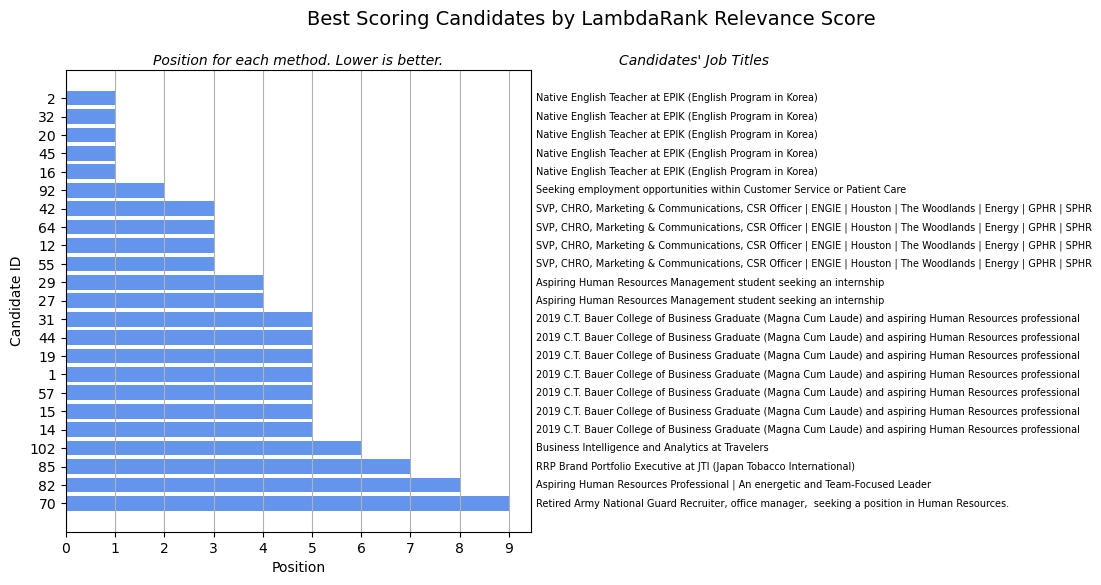

In [490]:
# convert the 'id' column to string to ensure categorical labeling
lambdarank_df['id'] = lambdarank_df['id'].astype(str)

# define threshold above which we won't consider/display candidates
threshold=10
top_lambda = lambdarank_df[lambdarank_df['position'] < threshold]

# plot the horizontal bar chart
plt.figure(figsize=(6, 6))
plt.barh(y=top_lambda['id'], 
         width=top_lambda['position'], 
         color='cornflowerblue')

xmax = axes.get_xlim()[1]  # maximum x-axis value

# add labels with scores from specified columns on the bars
for index, row in top_lambda.iterrows():
    # add the job_title to each corresponding applicant
    plt.text(
        xmax+0.1,
        row['id'],
        f"{row['job_title']}",
        ha='left',
        va='center',
        fontsize=7,
        color='black'
    )
    
# add labels and title for clarity
plt.ylabel('Candidate ID')
plt.xlabel('Position')
plt.suptitle('Best Scoring Candidates by LambdaRank Relevance Score', fontsize=14, x=1)

# add subtitle
axes=plt.gca()
ylim=axes.get_ylim()

plt.text(x=0.5, y=1.02, # position just above highest y-limit
         s='Position for each method. Lower is better.', 
         fontsize=10, 
         style='italic', 
         ha='center', 
         va='center',
         transform=plt.gca().transAxes)  # use axes-relative coordinates
plt.text(x=1.35, y=1.02,
         s="Candidates' Job Titles", 
         fontsize=10, 
         style='italic',
         ha='center',
         va='center',
         transform=plt.gca().transAxes)
plt.grid(axis='x')
# plt.xlim(0,threshold)
plt.gca().invert_yaxis()
plt.xticks(range(10))

plt.savefig('figures/3_lambdarank_scores.pdf',bbox_inches='tight')
plt.savefig('figures/3_lambdarank_scores.jpg',bbox_inches='tight')
plt.savefig('figures/3_lambdarank_scores.png',bbox_inches='tight')

plt.show()

In [434]:
# ranknet's scores
final_ranking_merged['position'] = final_ranking_merged['score'].rank(method='dense',ascending=False).astype(int)
final_ranking_merged.head()

,id,score,job_title,position
0,92,28,Seeking employment opportunities within Custom...,1
1,82,24,Aspiring Human Resources Professional | An ene...,2
2,22,22,People Development Coordinator at Ryan,3
3,32,22,Native English Teacher at EPIK (English Progra...,3
4,24,21,Aspiring Human Resources Specialist,4


In [435]:
# build merged dataframe
comparison = pd.merge(left=lambdarank_df[['id','position']], 
                      right=final_ranking_merged[['id','job_title','position']], 
                      left_on='id', 
                      right_on='id',
                      suffixes=['_lambda', '_ranknet'])
comparison.head()

,id,position_lambda,job_title,position_ranknet
0,2,1,Native English Teacher at EPIK (English Progra...,12
1,32,1,Native English Teacher at EPIK (English Progra...,3
2,20,1,Native English Teacher at EPIK (English Progra...,13
3,45,1,Native English Teacher at EPIK (English Progra...,9
4,16,1,Native English Teacher at EPIK (English Progra...,10


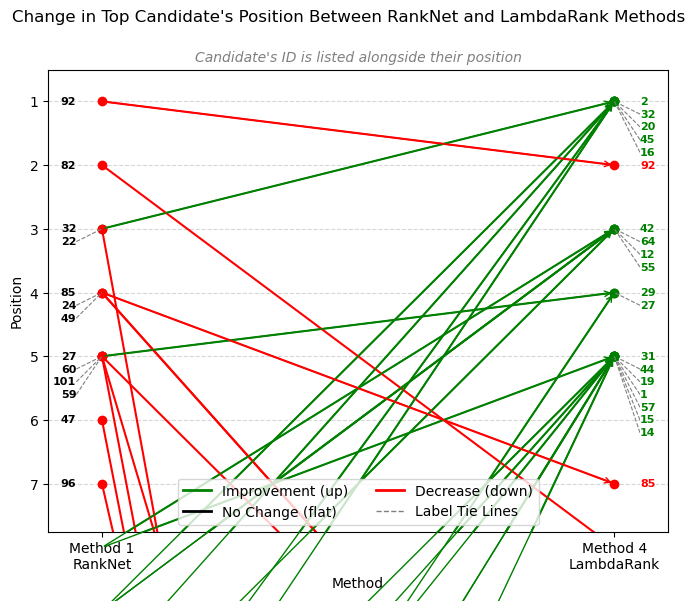

In [436]:
# Helper function to offset labels
def adjust_label_position(existing_positions, new_pos, offset=.2):
    while new_pos in existing_positions:
        new_pos += offset  # Adjust position to avoid overlap
    existing_positions.add(new_pos)
    return new_pos

# List of IDs to hide on left or right side because they're jumbled
hide_left_labels = []
hide_right_labels = []

# Define the maximum position rank to display labels
max_position_to_label = 7  # Only label candidates within this rank

plt.figure(figsize=(8, 6))

existing_positions_ranknet = set()  # Track used positions for left labels (cosine)
existing_positions_lambda = set()  # Track used positions for right labels (fasttext)

comparison = comparison[comparison['id'] != 47]

for _, row in comparison.iterrows():
    
    # Determine color for arrows and labels
    if row['position_lambda'] < row['position_ranknet']:
        arrow_color = 'green'  # Improvement (up)
        font_color = 'green'
    elif row['position_lambda'] > row['position_ranknet']:
        arrow_color = 'red'  # Decrease (down)
        font_color = 'red'
    else:
        arrow_color = 'black'  # No change (straight)
        font_color = 'black'
        
    # Draw lines between positions
    plt.plot(
        [1, 2],  # Time points
        [row['position_ranknet'], row['position_lambda']],  # Ranks
        marker='o',
        color=arrow_color,
        linestyle='-',
        clip_on=True
    )
    
    # Add arrows
    plt.annotate(
        '', 
        xy=(2, row['position_lambda']), 
        xytext=(1, row['position_ranknet']),
        arrowprops=dict(color=arrow_color, arrowstyle="->"),
        clip_on=True
    )
    
    # Label font weight (bold for top 10)
    left_fontweight = 'bold'
    right_fontweight = 'bold'

    # Adjust labels to avoid overlapping and check position limit
    fontsize = 8
    if row['position_ranknet'] <= max_position_to_label and row['id'] not in hide_left_labels:
        adjusted_position_ranknet = adjust_label_position(existing_positions_ranknet, row['position_ranknet'])
        plt.text(0.95, adjusted_position_ranknet, f"{int(row['id'])}", ha='right', va='center', 
                 fontsize=fontsize, fontweight=left_fontweight)
        if adjusted_position_ranknet != row['position_ranknet']:
            plt.plot([0.95, 1], 
                     [adjusted_position_ranknet, 
                      row['position_ranknet']], 
                     color='gray', 
                     linestyle='--', 
                     linewidth=0.8,
                     clip_on=True)

    if row['position_lambda'] <= max_position_to_label and row['id'] not in hide_right_labels:
        adjusted_position_lambda = adjust_label_position(existing_positions_lambda, row['position_lambda'])
        plt.text(2.05, adjusted_position_lambda, f"{int(row['id'])}", ha='left', va='center', 
                 fontsize=fontsize, fontweight=right_fontweight, color=font_color,
                 clip_on=True, bbox=dict(facecolor='white', edgecolor='none', pad=0.2))
        if adjusted_position_lambda != row['position_lambda']:
            plt.plot([2.05, 2], 
                     [adjusted_position_lambda, 
                      row['position_lambda']], 
                     color='gray', 
                     linestyle='--', 
                     linewidth=0.8,
                     clip_on=True)

# Define custom legend elements with simple lines instead of arrows
legend_elements = [
    Line2D([0], [1], color='green', lw=2, label='Improvement (up)'),
    Line2D([0], [1], color='black', lw=2, label='No Change (flat)'),
    Line2D([0], [1], color='red', lw=2, label='Decrease (down)'),
    Line2D([0], [1], color='gray', linestyle='--', lw=1, label='Label Tie Lines')
]

# Add legend to plot with a title
plt.legend(handles=legend_elements, loc='lower center', ncol=2, frameon=True)

# Customize plot
plt.xticks([1, 2], ['Method 1\nRankNet', 'Method 4\nLambdaRank'])
plt.gca().invert_yaxis()  # Rank 1 on top
plt.xlabel('Method')
plt.ylabel('Position')
plt.suptitle("Change in Top Candidate's Position Between RankNet and LambdaRank Methods", fontsize=12)
plt.title("Candidate's ID is listed alongside their position", fontstyle='italic', fontsize=10, color='grey')

# Set gridlines
y_min = 0
y_max = 25
plt.yticks(np.arange(y_min, y_max + 1, 1))
plt.gca().yaxis.grid(True)
plt.ylim(7.75, 0.5)

plt.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_clip_on(True)

plt.savefig('figures/3_pt2_comparison.pdf',bbox_inches='tight')
plt.savefig('figures/3_pt2_comparison.jpg',bbox_inches='tight')
plt.savefig('figures/3_pt2_comparison.png',bbox_inches='tight')

# Display the plot
plt.show()

I was unable to hide the green lines beyond the bounds of the box, but we can see that the two methods have different results. The point here is that the figure is jumbled - these two methods are clearly focusing on different aspects of the data when giving their ranks. I will also add that the dataset was small and as the company adds more candidates to their search, the models may be more equal in their determination.